In [ ]:
import pandas as pd
# Load the data into a pandas DataFrame
df = pd.read_csv('/content/credit_data.csv')
display(df.head())

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
# Fill missing values
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:
        df[column].fillna(df[column].median(), inplace=True)

/tmp/ipython-input-23-2178951576.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mode()[0], inplace=True)
/tmp/ipython-input-23-2178951576.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical features
le = LabelEncoder()
for col in ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']:
    df[col] = le.fit_transform(df[col])

# Handle 'Dependents' column: replace '3+' with 4 and convert to numeric
df['Dependents'] = df['Dependents'].replace('3+', 4)
df['Dependents'] = pd.to_numeric(df['Dependents'])

In [ ]:
import numpy as np

# Create new features
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['LoanAmount_log'] = np.log(df['LoanAmount'])

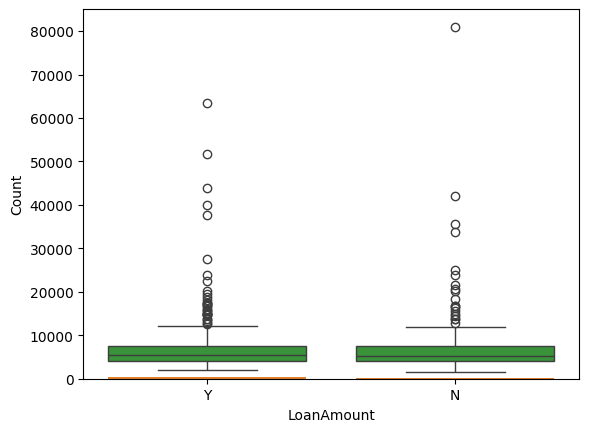

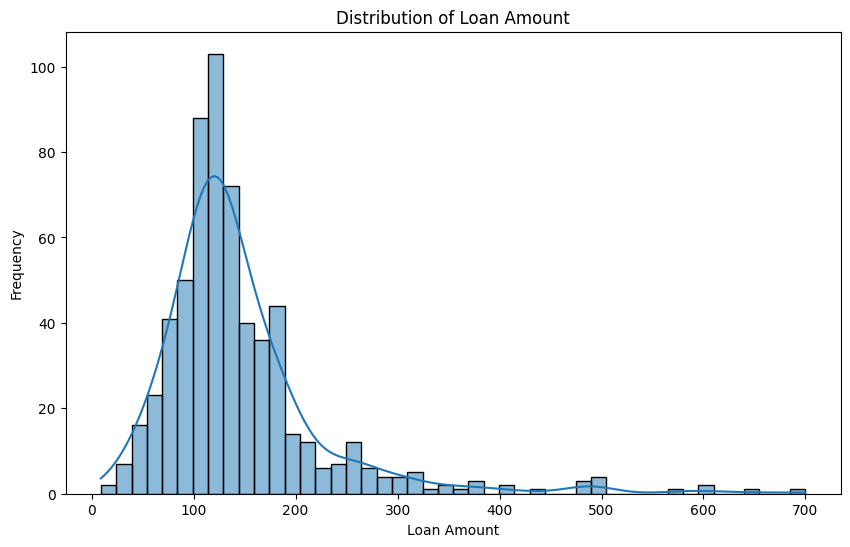

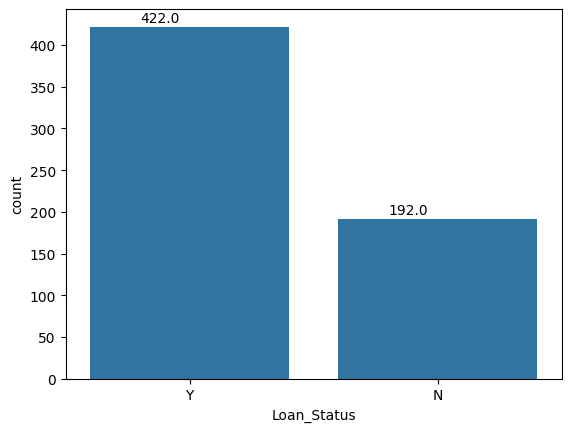

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the data
sns.histplot(df['LoanAmount'], kde=True)
sns.countplot(x='Loan_Status', data=df)
sns.boxplot(x='Loan_Status', y='Total_Income', data=df)

plt.figure(figsize=(10,6))
sns.histplot(df['LoanAmount'], kde=True)
plt.title('Distribution of Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()
ax = sns.countplot(x='Loan_Status', data=df)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.2, p.get_height()+5))

<Axes: >

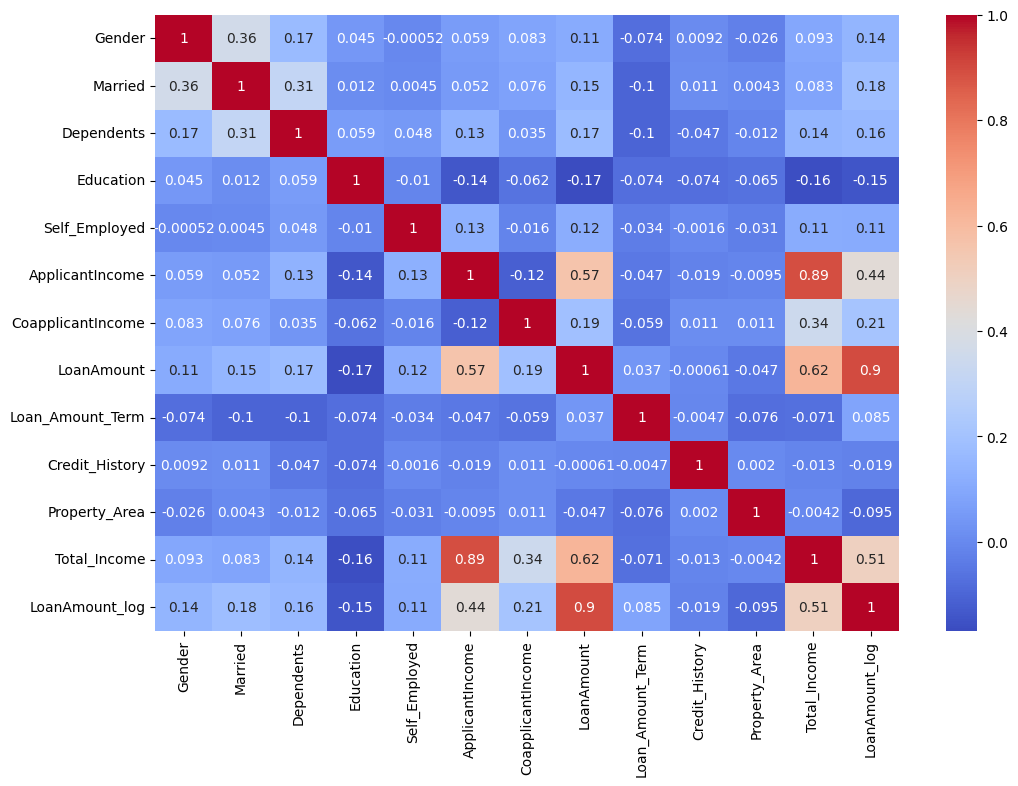

In [ ]:
plt.figure(figsize=(12,8))
# Drop the 'Loan_ID' column as it's not relevant for correlation analysis
df_numerical = df.drop('Loan_ID', axis=1)
sns.heatmap(df_numerical.corr(numeric_only=True), annot=True, cmap='coolwarm')

In [ ]:
# Define features (X) and target (y)
X = df.drop(['Loan_Status', 'Loan_ID'], axis=1)
y = df['Loan_Status'].map({'Y': 1, 'N': 0})

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data to handle class imbalance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train and evaluate Logistic Regression model
model = LogisticRegression()
model.fit(X_res, y_res)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[23 20]
 [11 69]]
              precision    recall  f1-score   support

           0       0.68      0.53      0.60        43
           1       0.78      0.86      0.82        80

    accuracy                           0.75       123
   macro avg       0.73      0.70      0.71       123
weighted avg       0.74      0.75      0.74       123



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from xgboost import XGBClassifier

# Train and evaluate XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_res, y_res)
y_pred_xgb = xgb.predict(X_test)

print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:55:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[21 22]
 [ 7 73]]
              precision    recall  f1-score   support

           0       0.75      0.49      0.59        43
           1       0.77      0.91      0.83        80

    accuracy                           0.76       123
   macro avg       0.76      0.70      0.71       123
weighted avg       0.76      0.76      0.75       123



ROC-AUC Score (XGBoost): 0.72


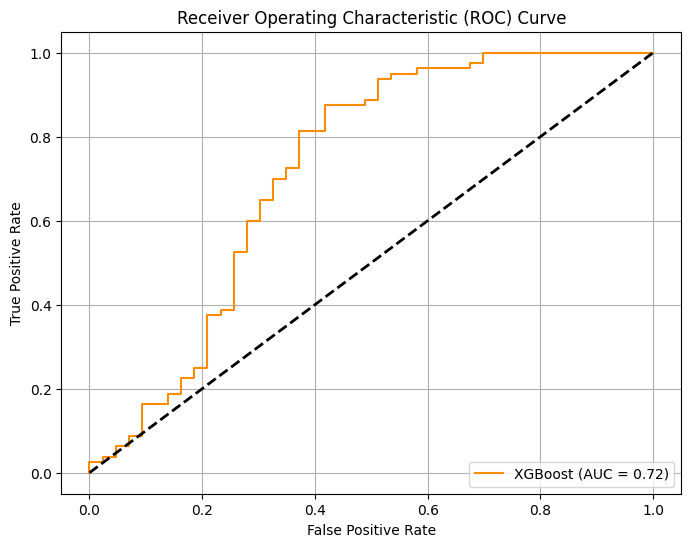

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC-AUC score
roc_auc_xgb = roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])
print(f"ROC-AUC Score (XGBoost): {roc_auc_xgb:.2f}")

# Plot ROC Curve with AUC in legend
fpr, tpr, _ = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})', color='darkorange')
plt.plot([0,1], [0,1], 'k--', lw=2)  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("roc_curve_xgb.png")  # Save the ROC plot for GitHub
plt.show()